<a href="https://colab.research.google.com/github/shekarramaswamy4/tf-sandbox/blob/master/tf_img-recog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q tensorflow_hub
from __future__ import absolute_import, division, print_function

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

tf.VERSION

'1.13.1'

In [3]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root))

228818944/228813984 [==============================] - 3s 0us/step
Found 3670 images belonging to 5 classes.


In [4]:
for img_batch, lbl_batch in image_data:
  print(img_batch.shape)
  print(lbl_batch.shape)
  break

(32, 256, 256, 3)
(32, 5)


In [8]:
classifier_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/2" #@param {type:"string"}
def classifier(x):
  classifier_module = hub.Module(classifier_url)
  return classifier_module(x)
  
IMAGE_SIZE = hub.get_expected_image_size(hub.Module(classifier_url))
print(IMAGE_SIZE)

image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
print(image_data[0][0].shape, image_data[1][0].shape)

classifier_layer = layers.Lambda(classifier, input_shape = IMAGE_SIZE+[3])
classifier_model = tf.keras.Sequential([classifier_layer])
classifier_model.summary()



[224, 224]
Found 3670 images belonging to 5 classes.
(32, 224, 224, 3) (32, 224, 224, 3)
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 04:03:54.950407 140459062953856 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 1001)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


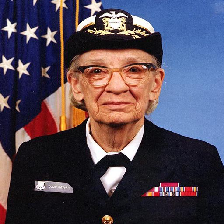

In [14]:
import tensorflow.keras.backend as K
sess = K.get_session()
init = tf.global_variables_initializer()

sess.run(init)

import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SIZE)
grace_hopper 

In [15]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SIZE)
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape
new_axis_gh = grace_hopper[np.newaxis, ...]
print(new_axis_gh.shape)

result = classifier_model.predict(new_axis_gh)
result.shape

(1, 224, 224, 3)


(1, 1001)

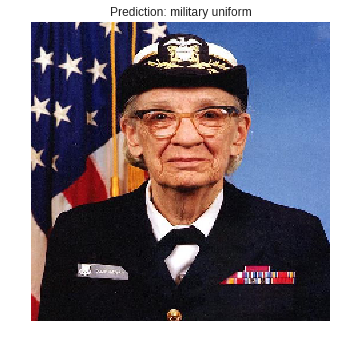

In [18]:
predicted_class = np.argmax(result[0], axis=-1)

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name)

Transfer learning tutorial starts here! Transfer learning is where a model developed for a task is reused as the starting point for a model on a second task.

In [20]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2" #@param {type:"string"}
def feature_extractor(x):
  feature_extractor_module = hub.Module(feature_extractor_url)
  return feature_extractor_module(x)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))
print(IMAGE_SIZE) # same as before

image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)


[224, 224]
Found 3670 images belonging to 5 classes.


In [21]:
features_extractor_layer = layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])
features_extractor_layer.trainable = False # don't train the already trained model
model = tf.keras.Sequential([
  features_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax') # this is the only layer that will be trained
])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 04:18:51.113419 140459062953856 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 6,405
Trainable params: 6,405
Non-trainable params: 0
_________________________________________________________________


In [0]:
init = tf.global_variables_initializer()
sess.run(init)

model.compile(
  optimizer=tf.train.AdamOptimizer(), 
  loss='categorical_crossentropy',
  metrics=['accuracy'])

model.fit((item for item in image_data), epochs=1, 
                    steps_per_epoch=image_data.samples)

Instructions for updating:
Use tf.cast instead.


W0409 04:28:30.458688 140459062953856 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


  32/3670 [..............................] - ETA: 1:39:24 - loss: 1.0370 - acc: 0.6172